In [1]:
import sys
sys.path.append('/global/home/users/erin_carroll/SUFHER')
from s2_imagery_prep import *

from joblib import Parallel, delayed 
import random
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
# define filepaths, generate output folders
aoi_name = 'GMUG_'
home = '/global/scratch/users/erin_carroll/'
tif_folder = home+'/data/tifs/'+aoi_name
years=range(2017,2025)
months=['jul','aug','sep']
tiles = ['12SXH','12SXJ','12SYG','12SYH','12SYJ','13SBB','13SBC','13SBD','13SCC','13SCD'] # previously identified in arc gis

In [3]:
# subset to tiles that are done downloading
t = tiles[5:]
t

['13SBB', '13SBC', '13SBD', '13SCC', '13SCD']

11452    12SXH
11453    12SXJ
11460    12SYG
11461    12SYH
11462    12SYJ
12355    13SBB
12356    13SBC
12357    13SBD
12365    13SCC
12366    13SCD
Name: Name, dtype: object


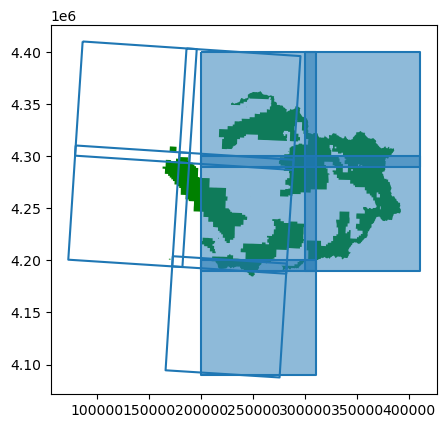

In [4]:
# visualize tiles

gmug = gpd.read_file(home+'/data/spatial_data/gmug').to_crs(32613)
s2_tiles = gpd.read_file(home+'/data/spatial_data/S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00').to_crs(32613)
s2_tiles = s2_tiles[s2_tiles['Name'].isin(tiles)]
print(s2_tiles['Name'])

fig, ax = plt.subplots()
gmug.plot(ax=ax, color='green')
s2_tiles[s2_tiles['Name'].isin(t)].plot(ax=ax, alpha=0.5)
s2_tiles.boundary.plot(ax=ax)
plt.show()

In [12]:
tiles = t
tiles

['13SBB', '13SBC', '13SBD', '13SCC', '13SCD']

In [ ]:
# unzip all tiles in parallel
# restructure this to eventually act on all zip folders, not tile folders individually. So can use more jobs and run across them! Even if just 28.
# should look into how to spread jobs across cores on multiple nodes? This could go very quickly which just a few nodes.

results = Parallel(n_jobs=5)(
    delayed(unzip_tiles)(tif_folder, tile) for tif_folder, tile in zip([tif_folder]*len(tiles), tiles)
)

In [13]:
results
# not sure why these didn't work, can always go back and redownload if feels helpful? E.g. if these month/years tiles look weird. But plenty of other data... oops lost them lol. There were 5 I think? from different tiles / years. 

[['/global/scratch/users/erin_carroll//data/tifs/GMUG_/13SBB/2020/aug/c70eceed-7c43-486d-a481-9662aca023b7.zip',
  '/global/scratch/users/erin_carroll//data/tifs/GMUG_/13SBB/2022/sep/6cbadfbd-126b-43b1-ba74-d889eaa10226.zip'],
 [],
 [],
 [],
 []]

In [14]:
folder_paths = sorted(glob.glob(tif_folder + '/*' + '/*' + '/*' + '/*.SAFE'))
print(folder_paths[0])
len(folder_paths)

/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2017/aug/S2A_MSIL2A_20170806T180921_N0500_R084_T12SXH_20230930T195342.SAFE


2951

In [ ]:
# generate all score tifs in parallel

results = Parallel(n_jobs=15)(
    delayed(generate_image_scores)(unzipped_folder_path) for unzipped_folder_path in folder_paths
)
results

In [18]:
len(results)

2951

In [ ]:
# generate argmax array for each tile / month / year

folder_paths = sorted(glob.glob(tif_folder + '/*' + '/*' + '/*'))

results = Parallel(n_jobs=4)(
    delayed(generate_argmax)(folder_path) for folder_path in folder_paths
)

results

In [ ]:
# mosaic each band / tile individually - bands and SCL!!

folder_paths = sorted(glob.glob(tif_folder + '/*' + '/*' + '/*'))

failed = Parallel(n_jobs=4)(
    delayed(mosaic_tiles)(folder_path) for folder_path in folder_paths
)

print(failed)

In [ ]:
# stack individually mosaicked bands into final mosaics

In [4]:
folder_paths = sorted(glob.glob(tif_folder + '/*' + '/*' + '/*'))
print(len(folder_paths))

failed = Parallel(n_jobs=20)(
    delayed(stack_bands_final_mosaic)(folder_path) for folder_path in folder_paths
)

240


In [ ]:
# Go back to check which tiles failed?

In [8]:
redo = []
for folder_path in folder_paths:
    t = folder_path.split('/')[9]
    y = folder_path.split('/')[10]
    m = folder_path.split('/')[11]
    fp_out = os.path.join(folder_path, f'{t}_{str(y)}_{m}_mosaic.tif')
    if not os.path.exists(fp_out):
        redo.append(fp_out)
redo

['/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/jul/12SXH_2024_jul_mosaic.tif',
 '/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/sep/12SXH_2024_sep_mosaic.tif',
 '/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXJ/2018/sep/12SXJ_2018_sep_mosaic.tif']

In [ ]:
# where did they fail?

# try redownloading raw files -
# t = "12SXH"
# years_ = [2024]
# months_ = ['jul', 'sep']
# skip = []
# download_raw_zip_files(username="erin_carroll@berkeley.edu", password="CQW_kc_2K-Pq!4u", years=years_, months=months_, tile=t, tif_folder=tif_folder, skip=skip)

# 12sxh jul 2024 - all downloaded, all score tifs generated, failed at argmax? Try run that again
# 12sxh sep 2024 - same as above
# 12sxj sep 2018 - same

In [17]:
# try to re-run argmax function

folder_paths = [
    tif_folder+'/12SXH/2024/jul',
    tif_folder+'/12SXH/2024/sep',
    tif_folder+'/12SXJ/2018/sep'
]

for folder_path in folder_paths:
    print(folder_path)
    generate_argmax(folder_path)

# looks like that worked - run next steps

/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/jul
/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/sep
/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXJ/2018/sep


In [18]:
for folder_path in folder_paths:
    print(folder_path)
    mosaic_tiles(folder_path, bands=bands)

/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/jul
/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/sep
/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXJ/2018/sep


In [19]:
for folder_path in folder_paths:
    print(folder_path)
    stack_bands_final_mosaic(folder_path)

/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/jul
/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXH/2024/sep
/global/scratch/users/erin_carroll//data/tifs/GMUG_/12SXJ/2018/sep


In [ ]:
# merge tiles for final year / month mosaics
# for now just random onrder the tiles and use first?

In [5]:
fps = glob.glob(tif_folder + '/*' + f'/{y}' + f'/{m}' + f'/*{y}_{m}_mosaic.tif')
fp = fps[0]
print(fp)
fp = fp.replace('.tif', '_TMP.tif')
print(fp)

/global/scratch/users/erin_carroll//data/tifs/GMUG_/13SBC/2018/jul/13SBC_2018_jul_mosaic.tif
/global/scratch/users/erin_carroll//data/tifs/GMUG_/13SBC/2018/jul/13SBC_2018_jul_mosaic_TMP.tif


In [ ]:
## don't merge final tiles! too big! no need! 2.79 TiB

# y = 2018
# m = 'jul'
# fp_out = tif_folder + f'/{aoi_name}{y}_{m}.tif'
# print(fp_out)

# src_files_to_mosaic = []
# fps = glob.glob(tif_folder + '/*' + f'/{y}' + f'/{m}' + f'/*{y}_{m}_mosaic.tif')
# for fp in fps:
#     with rasterio.open(fp) as src:
#         if src.crs != 'EPSG:32613':
#             print('old', fp, src.crs)
#             tmp_fp_out = fp.replace('.tif', '_TMP.tif')
#             reproject_raster(src, tmp_fp_out, 'EPSG:3613')
#             fp = tmp_fp_out
#     src = rasterio.open(fp)
#     print('final', fp, src.crs)
#     src_files_to_mosaic.append(src)

# random.shuffle(src_files_to_mosaic) # would I actulaly want this to be random or consistent across years??
# mosaic, out_transform = merge(src_files_to_mosaic, method='first', nodata=None)    




In [ ]:
# No I think this is unnecessary!
# # last step - calculate NDVI

# folder_paths = sorted(glob.glob(tif_folder + '/*' + '/*' + '/*'))
# print(len(folder_paths))

# results = Parallel(n_jobs=10)(
#     delayed(calulate_ndvi_ndmi)(folder_path) for folder_path in folder_paths
# )
